## More Dimensions

 Suppose we want to efficiently find out which entities in our geodatabase are within the latitude/longitude rectangle between 46.2386N8.5203E and 46.4193N8.7309E. We could build a range index as above on either latitude or longitude, but either dimension would return thousands of matching entities which we'd need to intersect in order to get the handful we want.

 ### Exercise
 Build a mono-dimensional index for longitude and find out how many entities exist within 8.5203 and 8.7309.
 
 ### Two-dimensional Index
 If we want to build an index that allows efficient querying along more than one dimension, things become slightly more complex. One option is to use a [Quadtree](https://en.wikipedia.org/wiki/Quadtre): instead of just storing `left` and `right` subtrees, our tree node could store four children, for example `ne`, `se`, `sw`, `ne`. When querying the tree, we select the matching subtree by comparing the query coordinates to the node's key, which is the lat/lng of the node's entity. We can then descend into the matching quadrant.

 Quadtrees work well for two dimensions, and you can imagine that an Octtree can be used to partition three-dimensional space. A generalization of that scheme are [k-d-Trees](https://en.wikipedia.org/wiki/K-d_tree), which can be used to partition by any number (the _k_ in _k_-dimensional) of dimensions. Instead of increasing the number of children per node, k-d-trees stick to a single partition, and instead cycles through the dimensions on each tree level.

 For example, for our latitude-longitude problem, the root node would have two children dividing the latitude dimension, whereas its grandchildren would divide the longitude dimension and the great-grandchildren again divide the latitude. By passing the _depth_ of the tree along any recursive function, we can determine the dimension being dividided by computing `depth % k`.

 #### Building a k-d-Tree
 A big challenge is finding the median entity in the current dimension when building the tree. In the one-dimensional case, all that was needed was a sorted list, for which we could easily compute the middle element of each sub-range of the list using bisection. For more than one dimension, this becomes tricky, even if we maintained a copy of the list sorted by each dimension:

<p float="left">
  <img src="https://docs.google.com/drawings/d/e/2PACX-1vRnpT_tavr-5qGnYQvB_Emc0EA4iJchrFavnuqrscm0YKJQyc-Fp_ZUNRYttaRwyVxb9AY09-dl2qFf/pub?w=482&h=368" />
  <img src="https://docs.google.com/drawings/d/e/2PACX-1vQrJ3_UUmAoGs4yTo_0E7XxKG96oqRqNMOEO8J8vrXyEpjL-US9KzXY7sSuc_NBBX_t_COBC7IJdnM9/pub?w=324&h=304" />
</p>

Finding the first latitude split point (long horizontal blue in the figure) is easy if we have a list of all points sorted by latitude: we select the median by computing the midpoint of the entire list, rounding down to the (blue) `3`. 

The second level splits happen along the longitude (vertical red lines). But how would we find the midpoint of the remaining points? Even if we do have a point list sorted by longitude, we don't know which of the points are still valid candidates, as some have been already moved to the other side of the latitude split.

### Preparing the Data
Instead of just a single key, each element has a list of keys, one for each dimension.

For a spatial index using latitude and longitude, the dimensionality is 2.

In [9]:
# We still use our toy dataset

towns = {
    0: {'name': 'Romanshorn', 'population': 11556, 'latitude': 47.56586, 'longitude': 9.37869},
    1: {'name': 'Amriswil', 'population': 14313, 'latitude': 47.54814, 'longitude': 9.30327},
    2: {'name': 'Arbon', 'population': 15459, 'latitude': 47.51360, 'longitude': 9.42999},
    3: {'name': 'Weinfelden', 'population': 11893, 'latitude': 47.56638, 'longitude': 9.10588},
    4: {'name': 'Frauenfeld', 'population': 26093, 'latitude': 47.55856, 'longitude': 8.89685},
    5: {'name': 'Kreuzlingen', 'population': 22788, 'latitude': 47.645837,'longitude': 9.178608},
    6: {'name': 'Egnach', 'population': 4897, 'latitude': 47.54565, 'longitude': 9.37864},
}

In [10]:
# Goal: Town tuples of the form (keys, value), where keys specifies the key for each dimension.
# Example:     0: {'name': 'Romanshorn', 'population': 11556, 'latitude': 47.56586, 'longitude': 9.37869},
# tuples = [
#   ((47.56586, 9.37869), 0),
#   ((47.23, 10.108), 3),
# ]
lat_lng_tuples = (((town['latitude'], town['longitude']), id) for id, town in towns.items())
lat_lng_tuples

<generator object <genexpr> at 0x108a2ba00>

### Build

The node of a kd-tree is really not different from any BST node, and we could simply re-use what we have.

Otherwise, building the tree is considerably more complex than the single-dimension case. While finding out which dimension we are on is not hard, the trouble comes from the fact that we cannot maintain a sorted tuple-list and use bisection to simply partition. Instead, we need a different approach to tell at each step which elements are covered by the node to be created:

#### Median Finding
Finding the ideal element that perfectly bisects the remaining elements is hard as we'd need to sort the elements to find the median. While [efficient median-finding algorithms](https://en.wikipedia.org/wiki/Selection_algorithm}) exist, we choose a simpler approach and just hope the elements are distributed somewhat randomly.

We simply insert nodes one after the other as we iterate over them. The first element becomes the root node, and we recursively insert each subsequent element by attaching it to as a new leaf node by following the nodes from the root.

In [11]:
class KdNode:
    """A node in a kd-tree."""
    def __init__(self, key, value):
        self.key = key
        self.value = value
        self.left = None
        self.right = None

from tqdm.auto import tqdm
def insert_node(parent, node, depth=0):
    """Recursively inserts a single node under parent."""
    keys = parent.key
    dimension_index = depth % len(keys)
    key = keys[dimension_index]
    if node.key[dimension_index] <= key:
        if parent.left is None:
            parent.left = node
        else:
            insert_node(parent.left, node, depth + 1)
    else:
        if parent.right is None:
            parent.right = node
        else:
            insert_node(parent.right, node, depth + 1)   

def build_kd_tree(tuples, max_count=None):
    """Build a kd-tree over tuples. Optionally, tell us how many elements to expect with max_count."""
    if max_count is None:
        try:
            max_count = len(tuples) - 1
        except:
            pass  # we received a generator and cannot know the length
    else:
        max_count -= 1

    tuples = iter(tuples)
    key, value = next(tuples)
    tree = KdNode(key, value)
    for key, value in tqdm(tuples, total=max_count):
        node = KdNode(key, value)
        insert_node(tree, node)
    return tree

kd_tree = build_kd_tree(lat_lng_tuples)

0it [00:00, ?it/s]

### Visualizing, Walking and Searching the KD-Tree
The kd-tree is a BST, so we can visualize and walk it as usual. Note that the order of the tree no longer corresponds to a _natural sort order_ as the order is only with respect to each level's dimension.

In [12]:
def walk_tree(tree):
    if tree is None:
        return
    yield from walk_tree(tree.left)
    yield tree
    yield from walk_tree(tree.right)

for node in walk_tree(kd_tree):
    print(node.key, node.value, towns[node.value]['name'])

(47.55856, 8.89685) 4 Frauenfeld
(47.54814, 9.30327) 1 Amriswil
(47.5136, 9.42999) 2 Arbon
(47.54565, 9.37864) 6 Egnach
(47.56586, 9.37869) 0 Romanshorn
(47.56638, 9.10588) 3 Weinfelden
(47.645837, 9.178608) 5 Kreuzlingen


Note: you may need to restart the kernel to use updated packages.


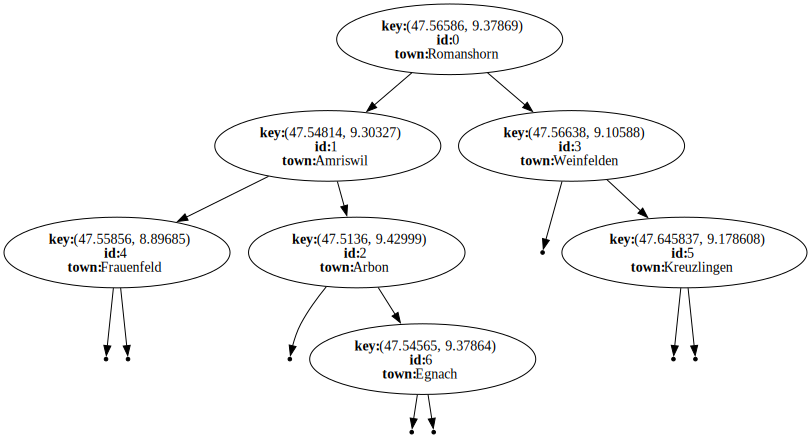

In [13]:
%pip install graphviz
import graphviz

def render_tree(graph, node, nuller=""):
    """Renders the tree in graphviz."""
    if node is None:
        # In order to have separate Nil-nodes, we need to create artificially
        # named nodes with unique names. We use the 'nuller' parameter to create
        # these, which is the left/right-path down from the root.
        graph.node(nuller, "", shape="point")
        return nuller
    
    id = str(node.key)
    graph.node(id, f"< <B>key:</B> {id}<BR/><B>id:</B> {str(node.value)}<BR/><B>town:</B> {towns[node.value]['name']} >")
    left_key = render_tree(graph, node.left, nuller + "l")
    graph.edge(id, left_key)
    right_key = render_tree(graph, node.right, nuller + "r")
    graph.edge(id, right_key)
    return id

dot = graphviz.Digraph("KD Search Tree")
render_tree(dot, kd_tree)
dot

Searching is again more complex than with the simple BST:

The decision to search or skip the subtrees is solely based on the node's dimension. Inclusion of the node itself however needs to check all dimensions, as we could well be within the range of the node's dimension but outside the search interval on other dimensions.

In [14]:
def is_within_bounds(point, rectangle):
    """Returns True if point is within the given (hyper-)rectangle, False otherwise."""
    # point: (47.56638, 9.10588)
    # rectangle: [(-90, 90), (-180, 180)]
    for (lower, upper), coord in zip(rectangle, point):
        if not lower <= coord <= upper:
            return False
    return True

def search_kd_tree(node, bounds, depth=0):
    """Searches a kd-tree and yields elements within the bounding (hyper-)rectangle."""
    # Example: key is (47.56638, 9.10588)
    # Depth is 0 (splitting on latitude direction)
    # bounds: [(-90, 90), (-180, 180)]

    if node is None:
        return
    
    # For deciding to search the subtrees, we only need to consider
    # the current dimension_index.
    dimension_index = depth % len(bounds)
    key = node.key[dimension_index]
    lower, upper = bounds[dimension_index]

    # If lower <= key, the search interval extends to our left.
    if lower <= key:
        yield from search_kd_tree(node.left, bounds, depth+1)
    
    # For inclusion, we need to check all dimensions, not just the current
    # dimension_index.
    if is_within_bounds(node.key, bounds):
        yield node
    
    # If key <= upper, the search interval extends to our right.
    if key <= upper:
        yield from search_kd_tree(node.right, bounds, depth+1)

# Search for all towns west of Weinfelden.
weinfelden = towns[3]
print(f"West of {weinfelden['name']}:")
results = search_kd_tree(kd_tree, [(-90, 90), (-180, weinfelden['longitude'])])
for node in results:
    print(node.key, node.value, towns[node.value]['name'])

# Search for all towns south of Arbon.
arbon = towns[2]
print(f"South of {arbon['name']}:")
for node in search_kd_tree(kd_tree, [(-90, arbon['latitude']), (-180, 180)]):
    print(node.key, node.value, towns[node.value]['name'])

# All towns in Oberthurgau
lower_left = (47.51282, 9.24036)
upper_right = (47.57679, 9.46421)
print("Towns in Oberthurgau:")
for node in search_kd_tree(kd_tree, [(lower_left[0], upper_right[0]), (lower_left[1], upper_right[1])]):
    print(node.key, node.value, towns[node.value]['name'])


West of Weinfelden:
(47.55856, 8.89685) 4 Frauenfeld
(47.56638, 9.10588) 3 Weinfelden
South of Arbon:
(47.5136, 9.42999) 2 Arbon
Towns in Oberthurgau:
(47.54814, 9.30327) 1 Amriswil
(47.5136, 9.42999) 2 Arbon
(47.54565, 9.37864) 6 Egnach
(47.56586, 9.37869) 0 Romanshorn


### Nearest Neighbor
The nearest-neighbor (NN) problem is to find the element (node) closest to a query. 

The algorithm descends the tree to find the leaf node that would be the parent of the query if it were to be inserted. From that point on, we retract back up along the parent chain of the leaf. At each level, we decide if the subtree on the other node could potentially contain points closer to the query than the best point found so far. If yes, that subtree is also searched using NN, otherwise, the subtree can be discarded. We are done when the walk-back reaches the root.

How do we decide if a subtree can be discarded? Knowing the distance of the currently known nearest neighbor node, we decide if the closest point in the subtree may be as close to the query as the current known best. Mathematically, we intersect a (hyper-)sphere with the radius of the current closest distance around the query with the (hyper-)rectangle defined by the subtree.

For distance, we use the L2 distance, but to speed things up, we use the squared distances to avoid the cost of computing square roots.

In [15]:
import copy

def sq_distance(one, two):
    """Returns the squared euclidian distance between two vectors one and two."""
    # FIXME use haversine function or proper geolib to compute wgs84 coordinate distance.
    return sum((c1-c2)**2 for c1,c2 in zip(one, two))

def hyperplane_distance(point, rectangle):
    """Returns the squared distance between the query point and the bounds hyper-rectangle."""
    # Compute the point on rectangle that is closest to point.
    # For each dimension, this is the point value if it is enclosed in the rectangle bound,
    # otherwise the corner of the rectangle.
    closest_point = []
    for coord, (lower, upper) in zip(point, rectangle):
        if coord < lower:
            closest_point.append(lower)
        elif upper < coord:
            closest_point.append(upper)
        else:
            # q is included in the interval - perpendicular on that side.
            closest_point.append(coord)
    return sq_distance(point, closest_point)

def select(left, right, is_left):
    return left if is_left else right

import math
def nearest_neighbor(node, query, bounds=[(-math.inf, math.inf), (-math.inf, math.inf)], depth=0, distance=math.inf):
    """Returns the nearest neighbor to query."""
    # Break at leaves
    if node is None:
        return None, math.inf

    # Descend to insertion point
    dimension_index = depth % len(query)
    key_dim = node.key[dimension_index]
    query_dim = query[dimension_index]
    bounds_dim = bounds[dimension_index]

    # Split the bounds (hyper-)rectangle at the node's position along the dimension.
    left_bounds = copy.copy(bounds)
    left_bounds[dimension_index] = (bounds_dim[0], key_dim)
    right_bounds = copy.copy(bounds)
    right_bounds[dimension_index] = (key_dim, bounds_dim[1])

    # First descend on the side of the insertion point:
    is_left = query_dim <= key_dim
    first_child = select(node.left, node.right, is_left)
    first_bounds = select(left_bounds, right_bounds, is_left)
    candidate, first_distance = nearest_neighbor(first_child, query, first_bounds, depth+1, distance)
    if candidate:
        distance = first_distance

    # Consider other side
    second_bounds = select(right_bounds, left_bounds, is_left)
    second_distance = hyperplane_distance(query, second_bounds)
    if second_distance >= distance:
        # Second side is not closer than our first candidate, we're done.
        return candidate, distance
    
    # Descend on the other side
    second_child = select(node.right, node.left, is_left)
    second_candidate, second_distance = nearest_neighbor(second_child, query, second_bounds, depth+1, distance)
    if second_candidate:
        candidate = second_candidate
        distance = second_distance

    # Finally, check if this node is better than what we've got so far.
    node_distance = sq_distance(node.key, query)
    if node_distance < distance:
        distance = node_distance
        candidate = node
    return candidate, distance

query = (47.5, 9.2)
nn, distance = nearest_neighbor(kd_tree, query)
print(towns[nn.value]['name'], math.sqrt(distance))


Amriswil 0.11393924916375263
